Columns in pan_otutab: Index(['OTU_ID', 'Subject-1067', 'Subject-1090', 'Subject-2032',
       'Subject-2065', 'Subject-3026', 'Subject-3061', 'Subject-4010',
       'Subject-4027', 'Subject-5003',
       ...
       'Subject-13029', 'Subject-1034', 'Subject-11023', 'Subject-13030',
       'Subject-1035', 'Subject-1006', 'Subject-1013', 'Subject-1014',
       'Subject-1007', 'Subject-1036'],
      dtype='object', length=1005)
Columns in pan_meta: Index(['Subject_ID', 'Geographical Location', 'Geographical zone in India',
       'Gender', 'AGE  in years', 'Life style pattern', 'BMI',
       'Obese-Non Obese'],
      dtype='object')
Column name mismatch. Checking similar names...
Renaming Subject-1067 and Subject_ID to 'Subject_ID'
Unique Subject_IDs in OTU table: 80
Unique Subject_IDs in Metadata: 1004
Number of common Subject_IDs: 0
Merged dataset shape: (0, 1012)


/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


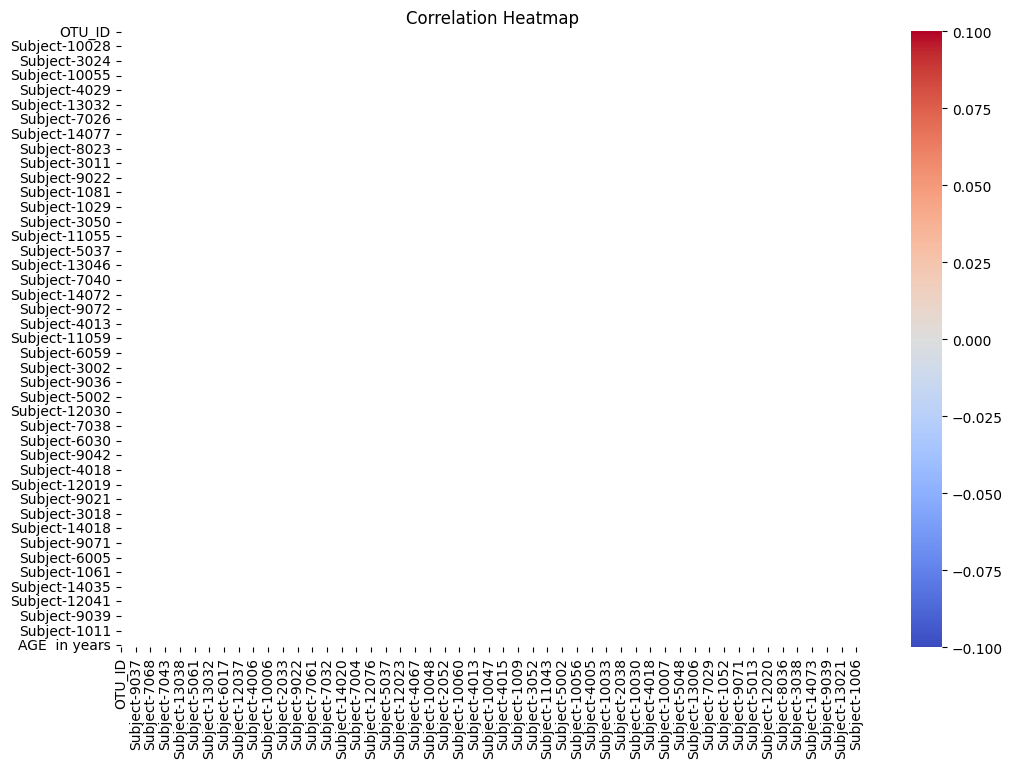

Columns in merged_data: ['OTU_ID', 'Subject_ID', 'Subject-1090', 'Subject-2032', 'Subject-2065', 'Subject-3026', 'Subject-3061', 'Subject-4010', 'Subject-4027', 'Subject-5003', 'Subject-5028', 'Subject-5053', 'Subject-6025', 'Subject-6048', 'Subject-6056', 'Subject-7088', 'Subject-7095', 'Subject-8015', 'Subject-8040', 'Subject-9012', 'Subject-9037', 'Subject-9062', 'Subject-10018', 'Subject-10024', 'Subject-10028', 'Subject-10065', 'Subject-11017', 'Subject-11022', 'Subject-11042', 'Subject-12014', 'Subject-12039', 'Subject-12059', 'Subject-12064', 'Subject-12070', 'Subject-13011', 'Subject-13037', 'Subject-14006', 'Subject-14031', 'Subject-14054', 'Subject-14079', 'Subject-7068', 'Subject-3015', 'Subject-1039', 'Subject-1047', 'Subject-1069', 'Subject-2010', 'Subject-2064', 'Subject-3042', 'Subject-3024', 'Subject-3062', 'Subject-4002', 'Subject-4048', 'Subject-4058', 'Subject-5007', 'Subject-5032', 'Subject-5055', 'Subject-6001', 'Subject-6050', 'Subject-6054', 'Subject-7024', 'Subj

ValueError: Found array with 0 sample(s) (shape=(0, 1009)) while a minimum of 1 is required by StandardScaler.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load
pan_meta = pd.read_csv("/content/pan_meta.csv")
pan_otutab = pd.read_csv("/content/pan_otutab.csv")

pan_meta.columns = pan_meta.columns.str.strip()
pan_otutab.columns = pan_otutab.columns.str.strip()

print("Columns in pan_otutab:", pan_otutab.columns)
print("Columns in pan_meta:", pan_meta.columns)

if "Subject_ID" not in pan_otutab.columns or "Subject_ID" not in pan_meta.columns:
    print("Column name mismatch. Checking similar names...")


    subject_col_otutab = [col for col in pan_otutab.columns if "subject" in col.lower()]
    subject_col_meta = [col for col in pan_meta.columns if "subject" in col.lower()]

    if subject_col_otutab and subject_col_meta:
        print(f"Renaming {subject_col_otutab[0]} and {subject_col_meta[0]} to 'Subject_ID'")
        pan_otutab.rename(columns={subject_col_otutab[0]: "Subject_ID"}, inplace=True)
        pan_meta.rename(columns={subject_col_meta[0]: "Subject_ID"}, inplace=True)
    else:
        raise ValueError("Could not find matching subject ID columns in both datasets.")

pan_otutab["Subject_ID"] = pan_otutab["Subject_ID"].astype(str)
pan_meta["Subject_ID"] = pan_meta["Subject_ID"].astype(str)

print("Unique Subject_IDs in OTU table:", pan_otutab["Subject_ID"].nunique())
print("Unique Subject_IDs in Metadata:", pan_meta["Subject_ID"].nunique())


common_subjects = set(pan_otutab["Subject_ID"]).intersection(set(pan_meta["Subject_ID"]))
print(f"Number of common Subject_IDs: {len(common_subjects)}")
merged_data = pan_otutab.merge(pan_meta, on="Subject_ID", how="inner")

print("Merged dataset shape:", merged_data.shape)
merged_data = pan_otutab.merge(pan_meta, on="Subject_ID", how="inner")

# Identifying the num parameter
numerical_targets = pan_meta.select_dtypes(include=[np.number]).columns.tolist()
if "Subject_ID" in numerical_targets:
    numerical_targets.remove("Subject_ID")


corr_matrix = merged_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

print("Columns in merged_data:", merged_data.columns.tolist())
print("Numerical targets:", numerical_targets)
print("Dropping columns:", [col for col in numerical_targets if col in merged_data.columns] + ["Subject_ID"])
otu_data = merged_data.drop(columns=numerical_targets + ["Subject_ID"], errors="ignore")
otu_data = otu_data.apply(pd.to_numeric, errors="coerce")
otu_data.fillna(0, inplace=True)

otu_data = merged_data.drop(columns=[col for col in numerical_targets if col in merged_data.columns] + ["Subject_ID"], errors="ignore")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(otu_data)
X_scaled_df = pd.DataFrame(X_scaled, index=otu_data.index, columns=otu_data.columns)
print("Scaling completed successfully.")


common_indices = merged_data.dropna(subset=numerical_targets).index
X_filtered = X_scaled_df.loc[common_indices]
y_filtered = merged_data.loc[common_indices, numerical_targets]

# Feature selection
selector = SelectFromModel(Lasso(alpha=0.1, max_iter=10000))
X_reduced = selector.fit_transform(X_filtered)

#TT Split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_filtered, test_size=0.2, random_state=42)

# LASSO
lasso_results = {}
lasso = Lasso(alpha=0.1, max_iter=10000)

for target in numerical_targets:
    y_target = y_train[target]

    lasso.fit(X_train, y_target)

    y_pred = lasso.predict(X_test)
    mse = mean_squared_error(y_test[target], y_pred)
    important_features = {otu: coef for otu, coef in zip(X_filtered.columns[selector.get_support()], lasso.coef_) if coef != 0}

    lasso_results[target] = {
        "MSE": mse,
        "Important OTUs": important_features
    }

# rESULTH
for target, result in lasso_results.items():
    print(f"\nLasso Regression for {target}")
    print(f"MSE: {result['MSE']:.4f}")
    print("Important OTUs:")
    for otu, coef in sorted(result['Important OTUs'].items(), key=lambda x: -abs(x[1]))[:10]:  # Show top 10 OTUs
        print(f"  {otu}: {coef:.4f}")


In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# Load the latest OTU file
otu_filepath = "/mnt/data/pan_otutab.csv"
otu_df = pd.read_csv(otu_filepath)
common_subjects = list(set(meta_df["Subject_ID"]) & set(otu_df.columns[1:]))

otu_filtered = otu_df[["OTU_ID"] + common_subjects].set_index("OTU_ID").T
meta_filtered = meta_df.set_index("Subject_ID").loc[common_subjects]

# Extract BMI as target variable and convert to numeric
y = pd.to_numeric(meta_filtered["BMI"], errors='coerce')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(otu_filtered.fillna(0))

# Cross Validation
lasso_cv = LassoCV(cv=5, random_state=42, n_alphas=100)
lasso_cv.fit(X_scaled, y)

# Extract coefficients and plot regularization path
lasso_coeffs = pd.Series(lasso_cv.coef_, index=otu_filtered.columns)
lasso_coeffs.sort_values(ascending=False).head(10)


In [ ]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import Lasso

# Reduce features: Keep only OTUs with high variance
selector = VarianceThreshold(threshold=0.001)  # Remove near-constant OTUs
X_reduced = selector.fit_transform(X_scaled)

# Perform LASSO regression with a higher iteration limit
lasso = Lasso(alpha=0.01, max_iter=5000, random_state=42)
lasso.fit(X_reduced, y)

# Extract nonzero coefficients to show selected OTUs
selected_otus = otu_filtered.columns[selector.get_support()]
lasso_coeffs = pd.Series(lasso.coef_, index=selected_otus)
lasso_coeffs[lasso_coeffs != 0].sort_values(ascending=False).head(10)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

alphas = np.logspace(-4, 0, 100)
lasso_paths = [Lasso(alpha=a, max_iter=5000).fit(X_reduced, y).coef_ for a in alphas]
lasso_paths = np.array(lasso_paths).T

#Plotting the regularization path
plt.figure(figsize=(10, 6))
for i in range(lasso_paths.shape[0]):
    plt.plot(alphas, lasso_paths[i], label=f'OTU {i}' if i < 5 else "", alpha=0.6)

plt.xscale("log")
plt.xlabel("Alpha (L1 penalty)")
plt.ylabel("Coefficient Value")
plt.title("LASSO Regularization Path")
plt.axvline(lasso.alpha_, color='red', linestyle="--", label="Selected Alpha")
plt.legend()
plt.show()


In [ ]:

variance = np.var(X_scaled, axis=0)
top_100_indices = np.argsort(variance)[-100:]
X_top100 = X_scaled[:, top_100_indices]

#Aloha values
alphas_subset = np.logspace(-3, -1, 20)
lasso_paths = [Lasso(alpha=a, max_iter=5000).fit(X_top100, y).coef_ for a in alphas_subset]
lasso_paths = np.array(lasso_paths).T

# Plot the regularization path
plt.figure(figsize=(10, 6))
for i in range(lasso_paths.shape[0]):
    plt.plot(alphas_subset, lasso_paths[i], label=f'OTU {i}' if i < 5 else "", alpha=0.6)

plt.xscale("log")
plt.xlabel("Alpha (L1 penalty)")
plt.ylabel("Coefficient Value")
plt.title("LASSO Regularization Path (Top 100 OTUs)")
plt.axvline(lasso.alpha_, color='red', linestyle="--", label="Selected Alpha")
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred_top100, alpha=0.6, label="Predicted vs. Actual", color="blue")

plt.xlabel("Actual BMI")
plt.ylabel("Predicted BMI")
plt.title(f"LASSO Regression (Top 100 OTUs): Actual vs Predicted BMI (R² = {r2_top100:.2f})")
plt.legend()
plt.show()
